In [1]:
# 2. Imports
import os
import shutil
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras import layers, models, optimizers, callbacks
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
# 3. Paths & Parameters
BASE_DIR = '/content/drive/MyDrive/wrist_xray'
train_dir = os.path.join(BASE_DIR, 'train')
val_dir = os.path.join(BASE_DIR, 'val')

IMG_SIZE = (299, 299)  # InceptionV3 requires 299x299
BATCH_SIZE = 32
VAL_SPLIT = 0.2
SEED = 42

In [3]:
# 4. Create train/val folders
for split_dir in [train_dir, val_dir]:
    for cls in ['Normal', 'Fracture']:
        os.makedirs(os.path.join(split_dir, cls), exist_ok=True)

In [4]:
# 5. Split & copy images
for cls in ['Normal', 'Fracture']:
    src = os.path.join(BASE_DIR, cls)
    imgs = [f for f in os.listdir(src) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    train_imgs, val_imgs = train_test_split(imgs, test_size=VAL_SPLIT, random_state=SEED)

    for fname in train_imgs:
        shutil.copy(os.path.join(src, fname), os.path.join(train_dir, cls, fname))
    for fname in val_imgs:
        shutil.copy(os.path.join(src, fname), os.path.join(val_dir, cls, fname))
print("✅ Dataset split into train/val folders")

✅ Dataset split into train/val folders


In [6]:
# 6. Data Generators & Augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # InceptionV3 specific
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=SEED
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 153 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [7]:
# 7. Compute Class Weights
counts = Counter(train_gen.classes)
total = sum(counts.values())
class_weight = {k: total/(2*v) for k,v in counts.items()}
print("Class weights:", class_weight)

Class weights: {np.int32(0): 0.8693181818181818, np.int32(1): 1.176923076923077}


In [8]:
# 8. Build Model
def build_model():
    base_model = InceptionV3(weights='imagenet',
                           include_top=False,
                           input_shape=(*IMG_SIZE, 3))
    base_model.trainable = False  # Freeze initially

    inputs = layers.Input(shape=(*IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    return models.Model(inputs, outputs)

model = build_model()
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,065,185 (84.17 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [9]:
# 9. Compile & Callbacks for Phase 1 (head only)
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    callbacks.ModelCheckpoint('best_inceptionv3.h5', save_best_only=True)
]

In [10]:
# 10. Train Head
history_head = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    class_weight=class_weight,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5121 - loss: 0.7754 - precision: 0.4330 - recall: 0.5961

5/5 ━━━━━━━━━━━━━━━━━━━━ 49s 7s/step - accuracy: 0.5128 - loss: 0.7753 - precision: 0.4339 - recall: 0.5788 - val_accuracy: 0.6250 - val_loss: 0.6601 - val_precision: 0.5714 - val_recall: 0.4706
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.4529 - loss: 0.8124 - precision: 0.4132 - recall: 0.4562

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4570 - loss: 0.8112 - precision: 0.4114 - recall: 0.4596 - val_accuracy: 0.6000 - val_loss: 0.6423 - val_precision: 0.5294 - val_recall: 0.5294
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5733 - loss: 0.6859 - precision: 0.4826 - recall: 0.4552

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5725 - loss: 0.6865 - precision: 0.4842 - recall: 0.4614 - val_accuracy: 0.6000 - val_loss: 0.6267 - val_precision: 0.5238 - val_recall: 0.6471
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.5385 - loss: 0.7532 - precision: 0.5116 - recall: 0.5942

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5402 - loss: 0.7498 - precision: 0.5053 - recall: 0.5874 - val_accuracy: 0.6000 - val_loss: 0.6227 - val_precision: 0.5200 - val_recall: 0.7647
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 835ms/step - accuracy: 0.5969 - loss: 0.6609 - precision: 0.5526 - recall: 0.4887

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5943 - loss: 0.6623 - precision: 0.5450 - recall: 0.4970 - val_accuracy: 0.6750 - val_loss: 0.6079 - val_precision: 0.5909 - val_recall: 0.7647
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.7109 - loss: 0.5688 - precision: 0.6285 - recall: 0.6576

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 979ms/step - accuracy: 0.7100 - loss: 0.5718 - precision: 0.6331 - recall: 0.6557 - val_accuracy: 0.7000 - val_loss: 0.5886 - val_precision: 0.6190 - val_recall: 0.7647
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.7163 - loss: 0.6003 - precision: 0.6784 - recall: 0.7296

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7080 - loss: 0.6066 - precision: 0.6640 - recall: 0.7234 - val_accuracy: 0.7250 - val_loss: 0.5794 - val_precision: 0.6250 - val_recall: 0.8824
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 964ms/step - accuracy: 0.7211 - loss: 0.5640 - precision: 0.6583 - recall: 0.7637

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7241 - loss: 0.5614 - precision: 0.6583 - recall: 0.7698 - val_accuracy: 0.7500 - val_loss: 0.5657 - val_precision: 0.6400 - val_recall: 0.9412
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.7258 - loss: 0.5631 - precision: 0.6744 - recall: 0.7512

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7301 - loss: 0.5565 - precision: 0.6779 - recall: 0.7491 - val_accuracy: 0.7000 - val_loss: 0.5353 - val_precision: 0.6316 - val_recall: 0.7059
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7909 - loss: 0.5096 - precision: 0.7440 - recall: 0.7144

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7931 - loss: 0.5072 - precision: 0.7511 - recall: 0.7184 - val_accuracy: 0.7750 - val_loss: 0.5163 - val_precision: 0.7500 - val_recall: 0.7059
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 725ms/step - accuracy: 0.7342 - loss: 0.5771 - precision: 0.6733 - recall: 0.6439

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7371 - loss: 0.5736 - precision: 0.6801 - recall: 0.6520 - val_accuracy: 0.7000 - val_loss: 0.5077 - val_precision: 0.6316 - val_recall: 0.7059
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 950ms/step - accuracy: 0.8182 - loss: 0.4426 - precision: 0.7645 - recall: 0.7770 - val_accuracy: 0.7750 - val_loss: 0.5083 - val_precision: 0.6667 - val_recall: 0.9412
Epoch 13/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7943 - loss: 0.4823 - precision: 0.7500 - recall: 0.8519 - val_accuracy: 0.8000 - val_loss: 0.5090 - val_precision: 0.6800 - val_recall: 1.0000
Epoch 14/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.7670 - loss: 0.4840 - precision: 0.6781 - recall: 0.8234

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 964ms/step - accuracy: 0.7666 - loss: 0.4810 - precision: 0.6815 - recall: 0.8169 - val_accuracy: 0.8000 - val_loss: 0.4797 - val_precision: 0.6800 - val_recall: 1.0000
Epoch 15/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - accuracy: 0.8585 - loss: 0.4060 - precision: 0.7795 - recall: 0.8694

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8527 - loss: 0.4113 - precision: 0.7795 - recall: 0.8604 - val_accuracy: 0.8000 - val_loss: 0.4586 - val_precision: 0.7368 - val_recall: 0.8235
Epoch 16/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7623 - loss: 0.4520 - precision: 0.7424 - recall: 0.7494

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7616 - loss: 0.4511 - precision: 0.7364 - recall: 0.7476 - val_accuracy: 0.8000 - val_loss: 0.4554 - val_precision: 0.6957 - val_recall: 0.9412
Epoch 17/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - accuracy: 0.8844 - loss: 0.3771 - precision: 0.8434 - recall: 0.8334

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 974ms/step - accuracy: 0.8819 - loss: 0.3812 - precision: 0.8477 - recall: 0.8304 - val_accuracy: 0.8000 - val_loss: 0.4516 - val_precision: 0.6800 - val_recall: 1.0000
Epoch 18/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9000 - loss: 0.3307 - precision: 0.8761 - recall: 0.9031 - val_accuracy: 0.8000 - val_loss: 0.4641 - val_precision: 0.6800 - val_recall: 1.0000
Epoch 19/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.7910 - loss: 0.4152 - precision: 0.6982 - recall: 0.9067

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 994ms/step - accuracy: 0.7899 - loss: 0.4175 - precision: 0.6970 - recall: 0.9043 - val_accuracy: 0.8250 - val_loss: 0.4287 - val_precision: 0.7273 - val_recall: 0.9412
Epoch 20/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 853ms/step - accuracy: 0.7928 - loss: 0.4451 - precision: 0.7973 - recall: 0.7692

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7947 - loss: 0.4434 - precision: 0.7913 - recall: 0.7718 - val_accuracy: 0.8250 - val_loss: 0.4109 - val_precision: 0.7778 - val_recall: 0.8235
Epoch 21/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8149 - loss: 0.4297 - precision: 0.8253 - recall: 0.7294

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8141 - loss: 0.4266 - precision: 0.8195 - recall: 0.7335 - val_accuracy: 0.8500 - val_loss: 0.4091 - val_precision: 0.7895 - val_recall: 0.8824
Epoch 22/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 839ms/step - accuracy: 0.8025 - loss: 0.4859 - precision: 0.8123 - recall: 0.7213 - val_accuracy: 0.8000 - val_loss: 0.4374 - val_precision: 0.6800 - val_recall: 1.0000
Epoch 23/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 921ms/step - accuracy: 0.8539 - loss: 0.3759 - precision: 0.7764 - recall: 0.8915 - val_accuracy: 0.8000 - val_loss: 0.4300 - val_precision: 0.6800 - val_recall: 1.0000
Epoch 24/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 849ms/step - accuracy: 0.8365 - loss: 0.3631 - precision: 0.7361 - recall: 0.9138 - val_accuracy: 0.8000 - val_loss: 0.4183 - val_precision: 0.6957 - val_recall: 0.9412
Epoch 25/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.8582 - loss: 0.2939 - precision: 0.7589 - recall: 0.9361

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 980ms/step - accuracy: 0.8557 - loss: 0.3011 - precision: 0.7590 - recall: 0.9339 - val_accuracy: 0.8500 - val_loss: 0.3948 - val_precision: 0.7619 - val_recall: 0.9412
Epoch 26/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8280 - loss: 0.3518 - precision: 0.7540 - recall: 0.8562

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8327 - loss: 0.3503 - precision: 0.7607 - recall: 0.8622 - val_accuracy: 0.8500 - val_loss: 0.3733 - val_precision: 0.8235 - val_recall: 0.8235
Epoch 27/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - accuracy: 0.8350 - loss: 0.4160 - precision: 0.8261 - recall: 0.8010

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8375 - loss: 0.4088 - precision: 0.8265 - recall: 0.8034 - val_accuracy: 0.8500 - val_loss: 0.3680 - val_precision: 0.8235 - val_recall: 0.8235
Epoch 28/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - accuracy: 0.8970 - loss: 0.2777 - precision: 0.8741 - recall: 0.8715

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8935 - loss: 0.2818 - precision: 0.8717 - recall: 0.8673 - val_accuracy: 0.9000 - val_loss: 0.3672 - val_precision: 0.8421 - val_recall: 0.9412
Epoch 29/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 864ms/step - accuracy: 0.8805 - loss: 0.3292 - precision: 0.9064 - recall: 0.8416 - val_accuracy: 0.8500 - val_loss: 0.3877 - val_precision: 0.7391 - val_recall: 1.0000
Epoch 30/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 813ms/step - accuracy: 0.8657 - loss: 0.3271 - precision: 0.7771 - recall: 0.8903 - val_accuracy: 0.8750 - val_loss: 0.3806 - val_precision: 0.7727 - val_recall: 1.0000


In [11]:
# 11. Phase 2: Unfreeze & Fine-Tune
# Unfreeze deeper inception blocks
for layer in model.layers[1].layers[-20:]:  # Unfreeze last 20 layers
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    initial_epoch=history_head.epoch[-1],
    class_weight=class_weight,
    callbacks=callbacks
)


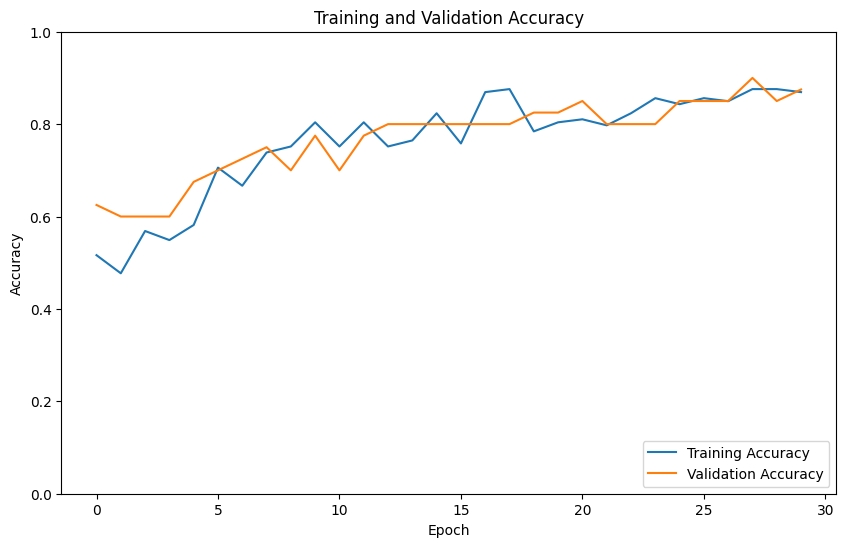

In [12]:
# 12. Plot Training Curves (Version-safe)
def plot_history(histories):
    # Check available keys to handle TF version differences
    key_mapping = {
        'train_acc': ['accuracy', 'acc'],
        'val_acc': ['val_accuracy', 'val_acc']
    }

    # Extract training accuracy
    train_acc = []
    for hist in histories:
        for key in key_mapping['train_acc']:
            if key in hist.history:
                train_acc += hist.history[key]
                break

    # Extract validation accuracy
    val_acc = []
    for hist in histories:
        for key in key_mapping['val_acc']:
            if key in hist.history:
                val_acc += hist.history[key]
                break

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.show()

plot_history([history_head, history_fine])

In [13]:
# 13. Evaluate
model.load_weights('best_inceptionv3.h5')
loss, acc = model.evaluate(val_gen)
print(f"\n✅ Final Validation Accuracy: {acc*100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.9021 - loss: 0.3601

✅ Final Validation Accuracy: 90.00%


In [14]:
def save_inception_safely(model, final_path):
    """Saves InceptionV3 model with Keras 3.x compatibility"""
    # Create temp paths
    weights_path = final_path.replace('.h5', '.weights.h5')
    arch_path = final_path.replace('.h5', '_arch.json')

    # Save components
    model.save_weights(weights_path)
    with open(arch_path, 'w') as f:
        f.write(model.to_json())

    # Reconstruct with custom objects
    reconstructed = tf.keras.models.model_from_json(
        open(arch_path).read(),
        custom_objects={'InceptionV3': InceptionV3}
    )
    reconstructed.load_weights(weights_path)
    reconstructed.save(final_path)

    # Cleanup
    os.remove(weights_path)
    os.remove(arch_path)
    print(f"✅ InceptionV3 saved: {final_path} ({os.path.getsize(final_path)/1e6:.1f} MB)")

# Usage after training
save_inception_safely(model, '/content/drive/MyDrive/inceptionv3_wrist_model_safe.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✅ InceptionV3 saved: /content/drive/MyDrive/inceptionv3_wrist_model_safe.h5 (106.5 MB)


In [15]:
# Check the saved model
dense_path = '/content/drive/MyDrive/inceptionv3_wrist_model_safe.h5'
print(f"File exists: {os.path.exists(dense_path)}")
print(f"File size: {os.path.getsize(dense_path)/1e6:.1f} MB")

# Try loading
densenet = tf.keras.models.load_model(
    dense_path,
    custom_objects={'InceptionV3': InceptionV3}
)
print("✅ Model loaded successfully!")

File exists: True
File size: 106.5 MB


✅ Model loaded successfully!


In [16]:
# 15. Prediction Function (same as original)
def predict_single_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]
    label = 'Fracture' if prediction < 0.5 else 'Normal'

    plt.imshow(img)
    plt.title(f"Prediction: {label} ({prediction:.4f})")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


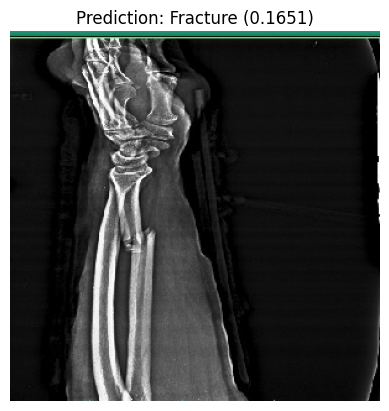

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


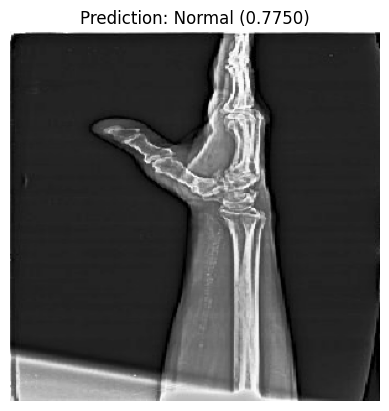

In [17]:
# Test prediction
predict_single_image('/content/drive/MyDrive/wrist_xray/Fracture/3 Male (L View).jpg')
predict_single_image('/content/drive/MyDrive/wrist_xray/Normal/1.jpg')
